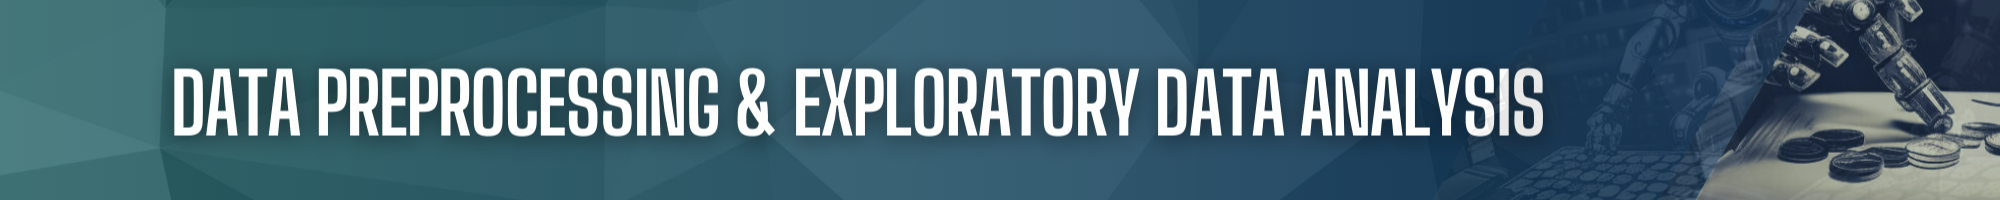

<div style="background-color: #f7f7f7; padding: 20px; border-radius: 10px; border: 2px solid #333333;">
<h1 style="font-family: Arial, sans-serif; color: #333333; text-align: center;">Gameplan</h1>
<ul style="font-family: Arial, sans-serif; color: #555555;">
<li><strong>Explore the raw dataframe:</strong> Begin by examining the size, shape, and distribution of the data. Conduct exploratory data analysis (EDA) to gain insights into the dataset, identify patterns, and understand the data's characteristics. Look for potential issues such as missing values, duplicates, or incorrect data types that need to be addressed.</li>
<li><strong>Clean the dataframe:</strong> Remove any unnecessary rows or columns from the dataframe. Handle missing values using appropriate methods, such as imputation or removal.</li>
<li><strong>Merge similar columns:</strong> Identify columns that serve the same purpose and consolidate them into a single column. This simplifies the dataframe and improves analysis efficiency.</li>
<li><strong>Clean values:</strong> Apply necessary transformations to the data, such as removing special characters, converting strings to numeric values, or adjusting formatting.</li>
<li><strong>Feature Engineering:</strong> Create new features or modify existing ones to enhance the dataset's suitability for machine learning training or analysis. Categorize values of parameters to adjust the dimensionality of the dataframe and represent variables more effectively.</li>
</ul>
<h1 style="font-family: Arial, sans-serif; color: #333333; text-align: center;">Goal</h1>
<ul style="font-family: Arial, sans-serif; color: #555555;">
<li><strong>Obtain a clean and prepared dataset:</strong> Produce a dataset that is free of errors, inconsistencies, and unnecessary elements. The resulting dataset should be well-prepared for subsequent machine learning training, analysis, or other tasks.</li>
</ul>
</div>

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
import ipywidgets as widgets
import re
import warnings
import scipy.stats as stats
warnings.simplefilter("ignore", FutureWarning)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import plotly.graph_objects as go

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the collected dataset to determine the precise measures necessary for data cleansing.</span>

</div>

In [19]:
def print_info_summary(dataframe):
    # Create a copy of the DataFrame
    df_copy = dataframe.copy()
    
    # Get the number of rows and columns in the DataFrame
    num_rows = df_copy.shape[0]
    num_columns = df_copy.shape[1]
    
    # Get the number of data cells in the DataFrame
    num_cells = num_rows * num_columns
    
    # Print the information
    print("\n\033[1mDataframe Summary: \033[0m\n")
    print("Number of Rows: ", num_rows)
    print("Number of Columns: ", num_columns)
    print("Number of Data Cells: ", num_cells)
    print("\n")
    
    # Create an HTML-style table for displaying the info summary
    info_table = pd.DataFrame({
        'Column': df_copy.columns,
        'Non-Null Count': df_copy.count(),
        'Dtype': df_copy.dtypes,
        'Unique Values': df_copy.nunique(),
        'Missing Values': df_copy.isnull().sum()
    }).rename_axis(None)  # Remove the 'Index' name

    # Display the info summary table as HTML
    display(HTML(info_table.to_html(index=False)))  # Exclude the index from HTML display

In [20]:
# Load the dataset
file_path = os.path.join(os.getcwd(), 'Data', 'coins_data_raw.csv')
df_raw = pd.read_csv(file_path, low_memory = False)

print_info_summary(df_raw)


Dataframe Summary: 

Number of Rows:  19053
Number of Columns:  80
Number of Data Cells:  1524240




Column,Non-Null Count,Dtype,Unique Values,Missing Values
Index,19053,int64,17852,0
Title,19053,object,15135,0
Rarity,18615,float64,96,438
Edge,14792,object,1027,4261
Mintage,11157,float64,4310,7896
Engraver,6462,object,1292,12591
Times Issued,19053,int64,109,0
Composition,18254,object,953,799
Currency,17270,object,1333,1783
Demonetized,10930,object,677,8123


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">
The dataset consists of over 1.5 million data cells, requiring a careful examination of its usefulness and subsequent data cleaning.

During the data collection process, a significant number of blank cells were recorded. To address this, the focus will be on establishing pre-cleaning functions and conducting a thorough exploration of the data.

<b>Current gameplan:</b>
- Merge the group of columns representing historical figures engraved on the coin into a single column named "Historical Figure" and assign binary values of 1 or 0 for categorization.
- Merge the "Issuer" column with the "Location" and "Issuing entity" columns, as they essentially represent the same information.
- Drop the following columns, as they provide no valuable purpose or contain a high number of missing values: "Number", "Orientation", "References", "Ruling authority", "Calendar", "Value", "Period", Size.
- The "Index" column can also be dropped from the dataframe since it has fulfilled its initial purpose and currently holds no meaningful value.
- Finally, assess the results and strategize for the next steps to be taken.
</span>

</div>


In [21]:
def merge_equivalent_columns(df):
    df_copy = df.copy()  # Create a copy of the dataframe
    df_copy["Historical Figure"] = 0  # Add a new column "Historical Figure" with initial value 0

    columns_to_merge = ["Legate", "Dauphin", "Abbot", "Raja", "Abbess", "Satrap", "Master", "Prince-abbot",
        "Caliph", "Voivode", "Ban", "Burgrave", "Governor", "Marquess", "Duchess", "Khan",
        "Archbishop", "Camerlengo", "Prime minister", "Tsar", "Caesar", "Archduke", "Doge",
        "Grand Prince", "Margrave", "Lord", "Grandmaster", "Landgrave", "Grand duchess",
        "Prince-bishop", "Bishop", "President", "Prince-archbishop", "Empress", "Co-prince",
        "Count", "Prince elector", "Regent", "Emir", "Shah", "Grand duke", "Sultan", "Duke",
        "Prince", "Pope", "Emperor", "Queen", "King", "Margravine", "Imam", "Countess"]

    for column in columns_to_merge:
        # Set value 1 in "Historical Figure" column for rows where the specified column is not empty
        df_copy.loc[df_copy[column].notna(), "Historical Figure"] = 1

    df_copy.drop(columns=columns_to_merge, inplace=True)  # Drop the specified columns
    return df_copy

In [22]:
def merge_issuer_columns(df):
    df_copy = df.copy()  # Create a copy of the dataframe
    
    # Iterate over the rows in the dataframe
    for index, row in df_copy.iterrows():
        issuer = row['Issuer']
        location = row['Location']
        issuing_entity = row['Issuing entity']
        
        # Check if both "Issuer" and "Location" columns are empty or NaN
        if pd.isnull(issuer) or issuer.strip() == "":
            if pd.isnull(location) or location.strip() == "":
                df_copy.at[index, 'Issuer'] = "Not available"
                df_copy.at[index, 'Location'] = "Not available"
            else:
                df_copy.at[index, 'Issuer'] = location.strip()  # Use "Location" as the value for "Issuer"
        else:
            # Check if only "Location" column is empty or NaN
            if pd.isnull(location) or location.strip() == "":
                df_copy.at[index, 'Location'] = "Not available"
        
        # Merge the "Issuing entity" column into the "Issuer" column
        if not pd.isnull(issuing_entity) and issuing_entity.strip() != "":
            df_copy.at[index, 'Issuer'] += " - " + issuing_entity.strip()
    
    df_copy.drop(['Location', 'Issuing entity'], axis=1, inplace=True)  # Drop the 'Location' and 'Issuing entity' columns
    return df_copy

In [23]:
# Create a copy of the dataframe for preprocessing and cleaning
df_cleaned = df_raw.copy()

# Execute initial dataset cleaning.
df_cleaned = merge_equivalent_columns(df_cleaned)
df_cleaned = merge_issuer_columns(df_cleaned)
df_cleaned = df_cleaned.drop("Index", axis=1)
df_cleaned = df_cleaned.drop("Number", axis=1)
df_cleaned = df_cleaned.drop("References", axis=1)
df_cleaned = df_cleaned.drop("Value", axis=1)
df_cleaned = df_cleaned.drop("Period", axis=1)
df_cleaned = df_cleaned.drop("Ruling authority", axis=1)
df_cleaned = df_cleaned.drop("Calendar", axis=1)

# Review the outcome and decide on the next course of action
print_info_summary(df_cleaned)


Dataframe Summary: 

Number of Rows:  19053
Number of Columns:  21
Number of Data Cells:  400113




Column,Non-Null Count,Dtype,Unique Values,Missing Values
Title,19053,object,15135,0
Rarity,18615,float64,96,438
Edge,14792,object,1027,4261
Mintage,11157,float64,4310,7896
Engraver,6462,object,1292,12591
Times Issued,19053,int64,109,0
Composition,18254,object,953,799
Currency,17270,object,1333,1783
Demonetized,10930,object,677,8123
Diameter,17433,object,1155,1620


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<h2 style="font-family: Arial, sans-serif; color: #555555;">Examining each column individually and addressing missing values</h2>

</div>

In [24]:
def print_column_info(df, column_name):
    column_info = df[column_name].describe()
    missing_values = df[column_name].isnull().sum()
    
    print("Column:", column_name)
    print(column_info)
    print("Missing values:", missing_values)

In [25]:
def print_unique_values_count(dataframe, column_name):
    # Make a copy of the DataFrame
    df_copy = dataframe.copy()
    
    # Get unique values and their counts
    value_counts = df_copy[column_name].value_counts()
    
    # Set display options for interactive scrolling
    pd.set_option('display.max_rows', pd.options.display.max_rows)
    pd.set_option('display.max_colwidth', None)
    
    # Generate HTML table with left alignment
    html_table = value_counts.to_frame().to_html(classes='table')
    
    # Create scrollable div element
    scrollable_html = f"<div style='overflow:auto; height:300px;'>{html_table}</div>"
    
    # Display the scrollable HTML table
    display(HTML(scrollable_html))

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  After examining the rows without a "Rarity" value, it was found that these rows do not contain any data.<br>Therefore, they will be removed from the dataset.</span>

</div>

In [26]:
def process_rarity_column(df):
    refined_df = df.copy()  # Create a copy of the original dataframe
    refined_df.dropna(subset=["Rarity"], inplace=True)  # Remove rows with missing data in the "Rarity" column
    refined_df["Rarity"] = refined_df["Rarity"].astype(int)  # Convert values to integers
    return refined_df

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Edge" column.</span>

</div>

In [27]:
print_column_info(df_cleaned,'Edge')
print_unique_values_count(df_cleaned, 'Edge')

Column: Edge
count      14792
unique      1027
top       Reeded
freq        4624
Name: Edge, dtype: object
Missing values: 4261


,Edge
Reeded,4624
Smooth,3856
Plain,2037
Milled,776
Smooth.,270
Segmented reeding,149
Smooth with inscription,114
Reeded.,109
Plain.,95
Corrugated,74


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">This function handles the "Edge" column by categorizing the values based on specific keywords. It performs a case-insensitive search for keywords such as "Reeded", "Smooth", "Plain", "Milled", "Gross", and "Lettered" in the values. If a value contains at least two of these keywords or none of them, it is assigned the category "Special". Otherwise, it assigns the capitalized form of the single keyword found. This process simplifies and consolidates the edge categories in the column.</span>
</div>

In [28]:
def process_edge_column(df):
    df_copy = df.copy()

    # Convert 'Edge' column to string type
    df_copy['Edge'] = df_copy['Edge'].astype(str)

    # Convert all values in 'Edge' column to lowercase
    df_copy['Edge'] = df_copy['Edge'].str.lower()

    # Define keywords
    keywords = ["reeded", "smooth", "plain", "milled", "gross", "letter"]

    # Function to categorize edge values
    def categorize_edge(value):
        count = sum(keyword in value for keyword in keywords)
        if count >= 2 or count == 0:
            return "Special"
        for keyword in keywords:
            if keyword in value:
                return keyword.capitalize()
        return "Special"

    # Apply the transformations
    df_copy['Edge'] = df_copy['Edge'].apply(categorize_edge)

    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Mintage" column.</span>

</div>

In [29]:
print_column_info(df_cleaned,'Mintage')

Column: Mintage
count        11157.00
mean      21724274.30
std       97647333.79
min              1.00
25%          10599.00
50%         271000.00
75%        5552000.00
max     2366770000.00
Name: Mintage, dtype: float64
Missing values: 7896


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">
<span style="font-family: Arial, sans-serif; color: #555555;">
Missing values will be replaced with '-1' to explicitly indicate the absence of data.
</span>
</div>


In [30]:
def process_mintage_column(df):
    df_copy = df.copy()

    # Replace missing values with -1
    df_copy['Mintage'].fillna(-1, inplace=True)

    # Values between 1 and 10 are insignificant and replaced with -1
    df_copy.loc[(df_copy['Mintage'] >= 1) & (df_copy['Mintage'] <= 10), 'Mintage'] = -1

    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Engraver" column.</span>

</div>

In [31]:
print_column_info(df_cleaned,'Engraver')

Column: Engraver
count                      6462
unique                     1292
top       Raphael David Maklouf
freq                        349
Name: Engraver, dtype: object
Missing values: 12591


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  The function replaces existing values with 1 and missing values with 0 in the "Engraver" column to indicate the presence or absence of engraver data.</span>

</div>

In [32]:
def process_engraver_column(df):
    df_copy = df.copy()  
    
    # Replace existing values with 1
    df_copy.loc[df_copy['Engraver'].notna(), 'Engraver'] = 1
    
    # Replace missing values with 0
    df_copy['Engraver'].fillna(0, inplace=True)
    
    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Composition" column.</span>

</div>

In [33]:
print_column_info(df_cleaned,'Composition')
print_unique_values_count(df_cleaned, 'Composition')

Column: Composition
count             18254
unique              953
top       Copper-nickel
freq               1805
Name: Composition, dtype: object
Missing values: 799


,Composition
Copper-nickel,1805
Silver (.925),1283
Copper,1269
Silver,1268
Brass,815
Bronze,752
Aluminium,663
Silver (.900),649
"Copper-nickel (75% Copper, 25% Nickel)",482
Silver (.999),426


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">This function processes the "Composition" column by consolidating and categorizing the composition types. It identifies specific metal keywords such as silver, gold, copper, etc., in the column values, converting them to uppercase. If a value contains multiple metal keywords, it is categorized as "Bimetallic". Values without any of these keywords are categorized as "Other". The function ensures a standardized representation of compositions in the dataset, improving data consistency.</span>

</div>

In [34]:
def process_composition_column(df):
    df_copy = df.copy()

    # Convert 'Composition' column to string type
    df_copy['Composition'] = df_copy['Composition'].astype(str)

    # Convert all values in 'Composition' column to lowercase
    df_copy['Composition'] = df_copy['Composition'].str.lower()

    # Define keywords
    keywords = ["silver", "gold", "copper", "brass", "bronze", "aluminum", "nickel", "billon", "zinc", "iron"]

    # Function to categorize composition values
    def categorize_composition(value):
        count = sum(keyword in value for keyword in keywords)
        if count == 1:
            for keyword in keywords:
                if keyword in value:
                    return keyword.capitalize()
        elif count >= 2:
            return "Bimetallic"
        return "Other"

    # Apply the transformations
    df_copy['Composition'] = df_copy['Composition'].apply(categorize_composition)

    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Currency" column.</span>

</div>

In [35]:
print_column_info(df_cleaned,'Currency')

Column: Currency
count                17270
unique                1333
top       Euro (2002-date)
freq                   827
Name: Currency, dtype: object
Missing values: 1783


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Assigning values to missing "Currency" based on the "Title" column. leveraging the relationship between the coin name and the currency it typically includes.</span>

</div>

In [36]:
def process_currency_column(df):
    df_copy = df.copy()
    
    # Assign missing "Currency" values based on "Title" column
    df_copy['Currency'].fillna(df_copy['Title'], inplace=True)
    
    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Demonetized" column.</span>

</div>

In [37]:
print_unique_values_count(df_cleaned, 'Demonetized')
print_column_info(df_cleaned,'Demonetized')

,Demonetized
Yes,7762
28 February 2002,200
1 March 2002,121
1991,82
17 February 2002,67
31 December 2001,46
1 January 1995,45
25 June 1928,39
31 December 2011,38
8 June 1992,33


Column: Demonetized
count     10930
unique      677
top         Yes
freq       7762
Name: Demonetized, dtype: object
Missing values: 8123


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">
<span style="font-family: Arial, sans-serif; color: #555555;">Handle missing values in the "Demonetized" column by leveraging information from the "Currency" column.<br>After careful examination of the "Currency" column, it became evident that circulating coins are denoted as "to date" in this column. Based on this observation, the strategy devised assigns a value of '1' to demonetized coins, '0' to circulating coins, and '-1' to cases where the status is unknown.</span>
</div>

In [38]:
def process_demonetized_column(df):
    df_copy = df.copy() 
    
    for index, row in df_copy.iterrows():
        demonetized_value = row['Demonetized']
        currency_value = row['Currency']
        
        if pd.notna(demonetized_value):
            # If 'Demonetized' value is not missing, assign '1' for demonetized coin
            df_copy.at[index, 'Demonetized'] = '1'
        elif 'date' in currency_value:
            # If 'Demonetized' value is missing and 'Currency' value contains 'date', assign '0' for circulating coin
            df_copy.at[index, 'Demonetized'] = '0'
        else:
            # If 'Demonetized' value is missing and 'Currency' value does not contain 'date', assign '-1' for unknown
            df_copy.at[index, 'Demonetized'] = '-1'
    
    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Diameter" column.</span>

</div>

In [39]:
print_column_info(df_cleaned,'Diameter')
print_unique_values_count(df_cleaned, 'Diameter')

Column: Diameter
count     17433
unique     1155
top       27 mm
freq        621
Name: Diameter, dtype: object
Missing values: 1620


,Diameter
27 mm,621
25 mm,577
30 mm,573
22 mm,551
23 mm,547
20 mm,520
38.61 mm,502
21 mm,493
24 mm,459
18 mm,421


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">
<span style="font-family: Arial, sans-serif; color: #555555;">The missing values in the "Diameter" column are handled using the median value approach.<br>By examining the existing values in the column, raplacing the missing values with the median.ensuring a reliable estimation for the missing diameters.</span>
</div>


In [40]:
def process_diameter_column(df):
    df_copy = df.copy()

    # Fill missing values in "Diameter" column with values from "Size" column
    missing_diameter_indices = df_copy["Diameter"].isnull()
    size_values = df_copy.loc[missing_diameter_indices, "Size"]
    df_copy.loc[missing_diameter_indices, "Diameter"] = size_values

    # Extract numeric part from "Diameter" column values and convert to floats
    df_copy["Diameter"] = df_copy["Diameter"].str.extract(r"(\d+\.?\d*)").astype(float)

    # Calculate the minimum and maximum values of the "Diameter" column
    min_diameter = df_copy["Diameter"].min()
    max_diameter = df_copy["Diameter"].max()

    # Replace missing values with the median diameter value, clamped within the range
    median_diameter = df_copy["Diameter"].median()
    missing_indices = df_copy["Diameter"].isnull()
    new_diameters = df_copy.loc[missing_indices, "Diameter"].fillna(median_diameter)
    new_diameters = new_diameters.clip(lower=min_diameter, upper=max_diameter)
    df_copy.loc[missing_indices, "Diameter"] = new_diameters

    # Drop the "Size" column as it holds no other useful information
    df_copy = df_copy.drop("Size", axis=1)

    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Orientation" column.</span>

</div>

In [41]:
print_column_info(df_cleaned,'Orientation')

Column: Orientation
count                  15442
unique                     4
top       Medal alignment ↑↑
freq                   10669
Name: Orientation, dtype: object
Missing values: 3611


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">
<span style="font-family: Arial, sans-serif; color: #555555;">Upon examining the available values in the column, it is determined that there are no specific patterns or frequent occurrences to infer the missing values.<br>Replacing the missing values with "unknown".</span>
</div>

In [42]:
def process_orientation_column(df):
    df_copy = df.copy()
    df_copy["Orientation"].fillna("unknown", inplace=True)
    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Shape" column.</span>

</div>

In [43]:
print_column_info(df_cleaned,'Shape')

Column: Shape
count     18605
unique      116
top       Round
freq      16064
Name: Shape, dtype: object
Missing values: 448


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">This function categorizes the values in the "Shape" column.<br>If a value is "Round", it is changed to "0". For all other values, they are changed to "1" (irregular shape). This process simplifies and standardizes the shape categories in the column.</span>

In [44]:
def process_shape_column(df):
    df_copy = df.copy()
    df_copy["Shape"] = df_copy["Shape"].fillna("")  # Replace NaN values with empty string

    # Map values based on conditions
    df_copy["Shape"] = df_copy["Shape"].apply(lambda x: "0" if x.lower() == "round" else "1")

    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Type" column.</span>

</div>

In [45]:
print_column_info(df_cleaned,'Type')

Column: Type
count                         18609
unique                           63
top       Standard circulation coin
freq                           9391
Name: Type, dtype: object
Missing values: 444


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">This function categorizes the values in the "Type" column based on specific keywords. Values containing keywords like "token", "award", "medal", "tourist", and "souvenir" are replaced with "Token/Medal". Additionally, it identifies and renames values with a unique count of less than 1000 to "Other". The function ensures a standardized and simplified representation of the "Type" categories in the dataset.</span>
</div>

In [46]:
def process_type_column(df):
    df_copy = df.copy()
    df_copy["Type"] = df_copy["Type"].fillna("")  # Replace NaN values with empty string

    # Map values based on keyword conditions
    keywords = ["token", "award", "medal", "tourist", "souvenir"]
    df_copy["Type"] = df_copy["Type"].apply(lambda x: "Token/Medal" if any(keyword.lower() in x.lower() for keyword in keywords) else x)

    # Check unique value counts
    unique_counts = df_copy["Type"].value_counts()
    values_to_rename = unique_counts[unique_counts < 1000].index.tolist()

    # Rename values with unique count < 1000 to "Other"
    df_copy.loc[df_copy["Type"].isin(values_to_rename), "Type"] = "Other"

    return df_copy


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  Examining the "Technique" column.</span>

</div>

In [47]:
print_column_info(df_cleaned,'Technique')
print_unique_values_count(df_cleaned, 'Technique')

Column: Technique
count      15064
unique        33
top       Milled
freq       13656
Name: Technique, dtype: object
Missing values: 3989


,Technique
Milled,13656
Hammered,939
"Milled, coloured",251
Cast,85
Coloured,20
"Milled, countermarked",20
Countermarked,14
"Milled, counterstamped",13
Klippe,10
Bracteate,10


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">
<span style="font-family: Arial, sans-serif; color: #555555;">This function categorizes the values in the "Technique" column into three options. Values containing the word "Hammered" are changed to "Hammered", values containing the word "Milled" are changed to "Milled", and all other values, including missing values, are changed to "Other". The function simplifies and standardizes the representation of techniques in the dataset while ensuring that missing values are uniformly categorized as "Other".</span>
</div>

In [48]:
def process_technique_column(df):
    df_copy = df.copy()
    df_copy["Technique"].fillna("Other", inplace=True)

    # Map values based on keyword conditions
    df_copy["Technique"] = df_copy["Technique"].apply(lambda x: "Hammered" if "Hammered" in x else ("Milled" if "Milled" in x else "Other"))

    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Examining the "Thickness " column.</span>

</div>

In [49]:
print_column_info(df_cleaned,'Thickness')
print_unique_values_count(df_cleaned, 'Thickness')

Column: Thickness
count     10321
unique      414
top        2 mm
freq        910
Name: Thickness, dtype: object
Missing values: 8732


,Thickness
2 mm,910
1.5 mm,523
3 mm,410
1 mm,396
1.8 mm,338
2.2 mm,330
1.7 mm,314
2.5 mm,310
1.6 mm,288
1.4 mm,244


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Convert the values to numerical format by extracting the numeric portion and discarding non-numeric parts.<br>After the conversion, fill the missing values with the median value within the new range.<br>This approach ensures consistent numerical values and maintains the overall distribution of the data.</span>

</div>

In [50]:
def process_thickness_column(df):
    df_copy = df.copy()
    
    # Convert numerical values in the "Thickness" column
    df_copy['Thickness'] = df_copy['Thickness'].str.extract(r'(\d+\.?\d*)').astype(float)
    
    # Calculate the median value
    median_thickness = df_copy['Thickness'].median()
    
    # Fill missing values with the median within the new range
    min_thickness = df_copy['Thickness'].min()
    max_thickness = df_copy['Thickness'].max()
    df_copy['Thickness'].fillna(median_thickness, inplace=True)
    df_copy.loc[df_copy['Thickness'] < min_thickness, 'Thickness'] = median_thickness
    df_copy.loc[df_copy['Thickness'] > max_thickness, 'Thickness'] = median_thickness
    
    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Examining the "Weight " column.</span>

</div>

In [51]:
print_column_info(df_cleaned,'Weight')
print_unique_values_count(df_cleaned, 'Weight')

Column: Weight
count       17516
unique       2590
top       28.28 g
freq          377
Name: Weight, dtype: object
Missing values: 1537


,Weight
28.28 g,377
5 g,323
10 g,274
4 g,254
2.5 g,228
8 g,195
2 g,194
20 g,191
3 g,186
8.5 g,186


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Remove the string part from the "Weight" column and extract the numeric values.<br>Calculate the mode (most frequent value) of the numeric values.<br>Replace missing values in the "Weight" column with the mode value, to ensure that the filled values align with the overall distribution of the data.</span>

</div>


In [52]:
def process_weight_column(df):
    df_copy = df.copy()

    # Remove the string part and extract the numeric value
    df_copy['Weight'] = df_copy['Weight'].str.extract('(\d+\.?\d*)').astype(float)

    # Calculate the mode (most frequent value)
    mode_value = df_copy['Weight'].mode().iloc[0]

    # Replace missing values with the mode
    df_copy['Weight'].fillna(mode_value, inplace=True)

    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Examining the "Years" column.</span>

</div>

In [53]:
print_column_info(df_cleaned,'Years')
print_unique_values_count(df_cleaned, 'Years')

Column: Years
count          7269
unique         3948
top       1999-2006
freq             48
Name: Years, dtype: object
Missing values: 11784


,Years
1999-2006,48
2002-2023,35
2002-2006,31
2002-2007,30
1937-1947,18
1937-1946,17
1948-1952,16
1920-1921,15
1998-1999,15
1966-1970,14


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">The "Years" column contains a significant number of missing values. However, I will leverage the available data in the "Years" column to compensate for the missing values in the "Year" column.</span>

</div>


In [54]:
def process_years_column(df):
    df_copy = df.copy()

    # Extract the first numeric value from values in the format "YYYY-YYYY(YYYY-YYYY)"
    df_copy['Years'] = df_copy['Years'].str.extract(r'^(\d+)')

    # Convert the column to numeric values
    df_copy['Years'] = pd.to_numeric(df_copy['Years'], errors='coerce')

    return df_copy

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Examining the "Year" column.</span>

</div>

In [55]:
print_column_info(df_cleaned,'Year')
print_unique_values_count(df_cleaned, 'Year')

Column: Year
count     10330
unique     1020
top        2014
freq        230
Name: Year, dtype: object
Missing values: 8723


,Year
2014,230
2008,228
2012,227
2009,226
2011,224
1994,221
2013,215
2000,212
2004,210
2006,204


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Process the "Year" column in the following steps:<br>1. Replace values in the format "YYYY(YYYY)" with the numeric value.<br>2. Replace values in the format "YYYY(YYYY-YYYY)" with the first value.<br>3. Remove the "BC" string and replace the numeric value with its negative value.<br>4. Fill missing values in the "Year" column from the "Years" column if available, otherwise assign "unknown".<br>5. Create a new column named "Century" based on the values in the "Year" column. The "Century" column categorizes the rows into decades by extracting the decade from the "Year" values.</span>

</div>


In [56]:
def process_year_column(df):
    df_copy = df.copy()

    # Replace values in the format "YYYY(YYYY)" with the numeric value inside the parentheses
    df_copy['Year'] = df_copy['Year'].str.replace(r'(\d+)\s*\(\s*(\d+)\s*\)', r'\2', regex=True)

    # Replace values in the format "YYYY(YYYY-YYYY)" with the first value inside the parentheses
    df_copy['Year'] = df_copy['Year'].str.replace(r'(\d+)\s*\(\s*(\d+)\s*-\s*(\d+)\s*\)', r'\2', regex=True)

    # Remove "BC" string and replace the numeric value with its negative value
    df_copy['Year'] = df_copy['Year'].str.replace(r'(\d+)\s*BC', r'-\1', regex=True)

    # Fill missing values from the "Years" column if available, otherwise assign "unknown"
    df_copy['Year'].fillna(df_copy['Years'], inplace=True)
    df_copy['Year'].fillna('unknown', inplace=True)

    # Create the "Century" column based on the "Year" column
    df_copy['Century'] = df_copy['Year'].apply(lambda x: str(int(x)//100) if (str(x).isdigit() or (str(x).startswith('-') and str(x)[1:].isdigit())) else 'unknown')

    # Remove the "Years" column
    df_copy = df_copy.drop("Years", axis=1)

    return df_copy



<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">
<span style="font-family: Arial, sans-serif; color: #555555;">Side-by-side comparison of the progress made, for effective checkpoint monitoring and identification of the next steps to be taken.</span>

</div>

In [57]:
def compare_dataframes(df_before, df_after):
    # Create a dataframe to store the comparison results
    comparison_df = pd.DataFrame(columns=['', 'Before', 'After'])
    
    # Calculate the data cell count for both dataframes
    data_cell_count_before = df_before.size
    data_cell_count_after = df_after.size
    
    # Calculate the number of rows for both dataframes
    rows_before = df_before.shape[0]
    rows_after = df_after.shape[0]
    
    # Calculate the number of columns for both dataframes
    columns_before = df_before.shape[1]
    columns_after = df_after.shape[1]
    
    # Add the metrics and corresponding values to the comparison dataframe
    comparison_df.loc[0] = ['Data Cell Count', data_cell_count_before, data_cell_count_after]
    comparison_df.loc[1] = ['Rows', rows_before, rows_after]
    comparison_df.loc[2] = ['Columns', columns_before, columns_after]
    
    # Set an empty string as the index name
    comparison_df.set_index('', inplace=True)
    
    # Transpose the table
    comparison_df = comparison_df.transpose()
    
    # Set font size, alignment, and color for comparison table
    comparison_styles = [
        {'selector': '',
         'props': [('font-size', '16px'),
                   ('text-align', 'right')]},
        {'selector': 'th, td',
         'props': [('border', '1px solid black'),
                   ('padding', '5px'),
                   ('text-align', 'center'),
                   ('background-color', '#f7f7f7'),
                   ('color', '#333333')]},
        {'selector': 'th',
         'props': [('background-color', '#eaeaea')]}
    ]
    comparison_df = comparison_df.style.set_table_styles(comparison_styles)
    
    # Additional information table
    info_df = pd.DataFrame(columns=['', 'Value'])
    
    # Calculate rows deleted
    rows_deleted = rows_before - rows_after
    info_df.loc[0] = ['Rows deleted', rows_deleted]
    
    # Calculate columns deleted
    columns_deleted = columns_before - columns_after
    info_df.loc[1] = ['Columns deleted', columns_deleted]
    
    # Calculate total count of missing values in df_after
    total_missing_values = df_after.isnull().sum().sum()
    info_df.loc[2] = ['Missing values remaining', total_missing_values]
    
    # Calculate percentage of deleted rows
    percentage_deleted_rows = (rows_deleted / rows_before) * 100
    info_df.loc[3] = ['Percentage of deleted rows', f'{percentage_deleted_rows:.2f}%']
    
    # Calculate percentage of deleted cells
    percentage_deleted_cells = (data_cell_count_before - data_cell_count_after) / data_cell_count_before * 100
    info_df.loc[4] = ['Percentage of deleted cells', f'{percentage_deleted_cells:.2f}%']
    
    # Set an empty string as the index name
    info_df.set_index('', inplace=True)
    
    # Transpose the additional information table
    info_df = info_df.transpose()
    
    # Set font size, alignment, and color for additional information table
    info_styles = [
        {'selector': '',
         'props': [('font-size', '16px'),
                   ('text-align', 'right')]},
        {'selector': 'th, td',
         'props': [('border', '1px solid black'),
                   ('padding', '5px'),
                   ('text-align', 'center'),
                   ('background-color', '#f7f7f7'),
                   ('color', '#333333')]},
        {'selector': 'th',
         'props': [('background-color', '#eaeaea')]}
    ]
    info_df = info_df.style.set_table_styles(info_styles)

    # Display the comparison table with title
    display(HTML('<h2 style="text-align: left; color: #333333">Before and After Clean</h2>'))
    display(HTML('<div style="text-align: left">' + comparison_df.render() + '</div>'))
    
    # Display the additional information table with title
    display(HTML('<h2 style="text-align: left; color: #333333">Summary of Actions</h2>'))
    display(HTML('<div style="text-align: left">' + info_df.render() + '</div>'))


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Executing pre-processing functions.</span>

</div>


In [58]:
functions_to_apply = [
    process_rarity_column,
    process_edge_column,
    process_mintage_column,
    process_engraver_column,
    process_composition_column,
    process_currency_column,
    process_demonetized_column,
    process_diameter_column,
    process_orientation_column,
    process_shape_column,
    process_type_column,
    process_technique_column,
    process_thickness_column,
    process_weight_column,
    process_years_column,
    process_year_column
]

for func in functions_to_apply:
    df_cleaned = func(df_cleaned)

In [59]:
print_info_summary(df_cleaned)
compare_dataframes(df_raw, df_cleaned)


Dataframe Summary: 

Number of Rows:  18615
Number of Columns:  20
Number of Data Cells:  372300




Column,Non-Null Count,Dtype,Unique Values,Missing Values
Title,18615,object,14752,0
Rarity,18615,int32,96,0
Edge,18615,object,7,0
Mintage,18615,float64,4301,0
Engraver,18615,int64,2,0
Times Issued,18615,int64,109,0
Composition,18615,object,12,0
Currency,18615,object,2595,0
Demonetized,18615,object,3,0
Diameter,18615,float64,999,0


,Data Cell Count,Rows,Columns
Before,1524240,19053,80
After,372300,18615,20


,Rows deleted,Columns deleted,Missing values remaining,Percentage of deleted rows,Percentage of deleted cells
Value,438,60,0,2.30%,75.57%
